Activate the Project Environments

In [1]:
] activate ..

  Activating environment at `e:\Pythonfiles\JP\ML\Project.toml`


Loading the packages needed

In [2]:
using DifferentialEquations
using LinearAlgebra, DiffEqSensitivity, Optim
using Flux: flatten, params
using DiffEqFlux, Flux
using Plots
using Flux: train!
using NNlib

# Chapter one: Discovering unknown mechanisms in transmission dynamics

Universal differential equations can be used in
* identifying known parts of a model (parameter estimation)
* capturing the missing mechanisms
* discovering unknown mechanisms
* optimal control
* continuous normalizing flows

In this chapter, we will use UDE to discover unknown or unclear mechanisms in transmission models. 

## 1.1 Discovering unclear incidence rate

### 1.1.1 Quadratic or subexponential growth of disease

As a first example, UDE is applied to discover  the quadratic or subexponential growth of dynamics. Specifically,
We will generate data from
$$u'(t) = r u^\alpha $$
and use the following universal differential equation to learn the model
$$u'(t) = NN(u).$$

#### Model One: Example one. 
$$ r=1, \alpha =1$$


In [3]:
function model1(du,u,p,t)
     r, α = p
    du .= r.*u.^α
end
u_0 = [1.0]
p_data = [1.0,1.0]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(model1,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(model1,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
"""
scatter(data_solve.t, data[1,:],label = "Train N")
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(model1,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
plot!(test_data, label="Test N")
"""

"scatter(data_solve.t, data[1,:],label = \"Train N\")\ntspan_predict = (0.0, 4.0)\nprob_predict = ODEProblem(model1,u_0,tspan_predict,p_data)\ntest_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)\nplot!(test_data, label=\"Test N\")\n"

[1.0 0.8542567570637498 0.7297546086976898 0.6233978036710363 0.5325417842695529 0.45492742146186216 0.38862482758269623 0.33198538126488125 0.28360073602846436 0.24226784885199765 0.2069589668482709 0.17679607349318546 0.15102924025090161 0.12901776996557532 0.11021426897106032 0.09415131779837654 0.08042937651906781 0.06870734909678143 0.05869371532802254 0.05013949738871704 0.04283201236664193 0.03658952833800385 0.031256856436677284 0.02670138354635051 0.02280982684902257 0.01948547107209631 0.01664556453293821 0.014219618187090532 0.012147175180493418 0.010376822990251066 0.008864485371736695]
1518.4001279291124
66.2888905407442
43.82318543321431
37.39276329586461
30.89454077150659
24.601264623880112
18.818472123332594
13.78002115853359
9.627833672428226
6.40092764127719
[1.0000000022661328, -1.1338830526882407e-8]


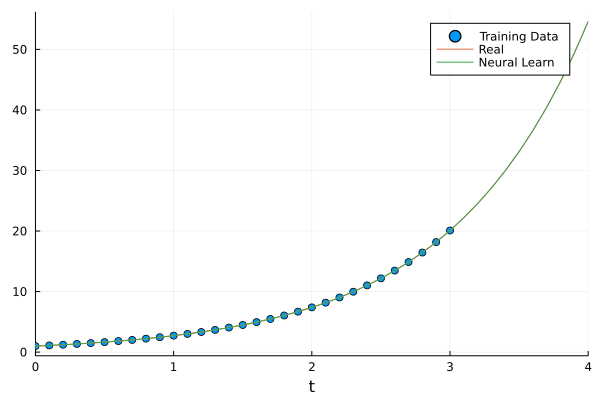

In [4]:
ann_node = FastChain(FastDense(1, 1))
p = Float64.(initial_params(ann_node))
function model1_nn(du,u,p,t)
    du[1] =  ann_node(u,p)[1]
end
prob_nn = ODEProblem(model1_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
println(res2_node.minimizer)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data, label="Real")

prob_nn2 = ODEProblem(model1_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label="Neural Learn")

Compare 
$$f(u)=u, NN(u)$$

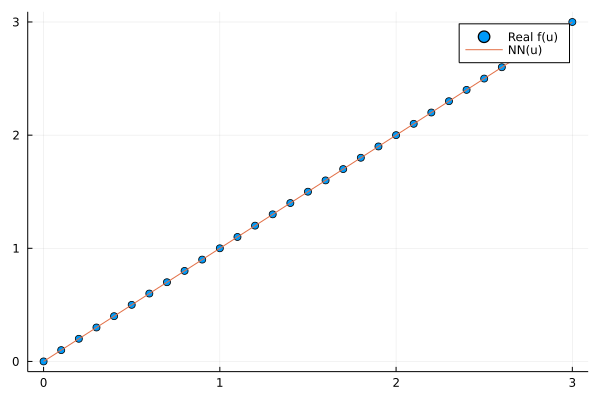

In [5]:
scatter(data_solve.t, data_solve.t, label = "Real f(u)")
plot!(data_solve.t, ann_node(data_solve.t',res2_node.minimizer)',label="NN(u)")

#### Model one: Example Two. 
$$ r=0.2, \alpha =0.5$$
i.e.,
$$u'(t) = 0.2 u^{0.5}$$


0.03155404493558321


0.021784709040953084
0.015126764895638002
0.00964075364127891
0.005639223944409264
0.0030283543847827517
0.0014957040201697294
0.0006837558945775928
0.0002943611884580576
0.00012466056636293693
1.1203340829958296e-9
[-0.7096962025870669, 0.3331787335742234, -0.5690980879546885, 0.4672915769756635, -0.48657472376735467, 0.5339222764014867, -0.5209453564625827, 0.0453569315651579, -0.023925875562056553, -0.03380722883507315, 0.0016763619830224836, 0.009531006471801771, 0.04036963737439724, -0.013437485403611156, 0.025511136375505967, 0.008067627796961147, 0.01565181613257695, 0.042182069969577775, -0.027032992364527254, -0.022847886609724245, -0.20640643515849771, 0.6067406174715401, 0.17092527332578833, -0.4433114399431342, 0.31705328740852573, 0.25509974193031737, -0.16507393662499895, 0.2529384491661406, -0.5297899832568815, -0.090408576752574, 0.024633704342274618]


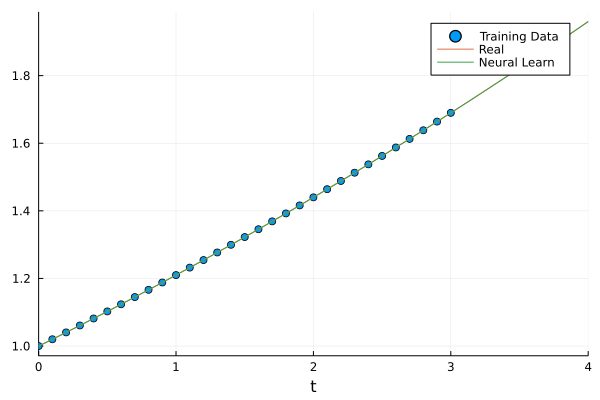

In [6]:
function model2(du,u,p,t)
    r, α = p
   du .= r.*u.^α
end
u_0 = [1.0]
p_data = [0.2,0.5]
tspan_data = (0.0, 3.0)
prob_data_1 = ODEProblem(model2,u_0,tspan_data,p_data)
data_solve = solve(prob_data_1, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(model2,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(1, 10,tanh),FastDense(10, 1))
p = Float64.(initial_params(ann_node))
function model2_nn(du,u,p,t)
    du[1] =  ann_node(u,p)[1]
end
prob_nn = ODEProblem(model2_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
println(res2_node.minimizer)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data, label="Real")

prob_nn2 = ODEProblem(model2_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label="Neural Learn")

Compare 
$$f(u)=0.2u^{0.5}, NN(u)$$

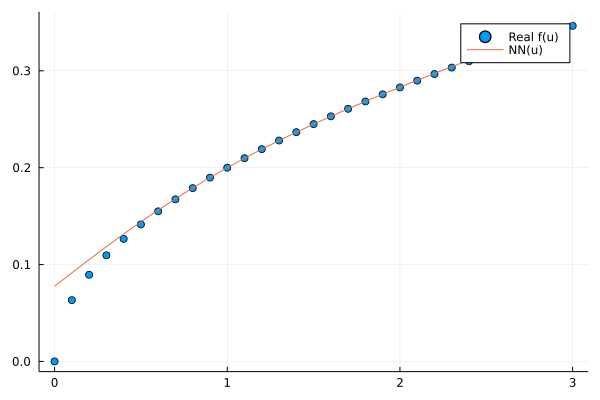

In [7]:
scatter(data_solve.t, 0.2.*data_solve.t.^0.5, label = "Real f(u)")
plot!(data_solve.t, ann_node(data_solve.t',res2_node.minimizer)',label="NN(u)")

#### Model one: Example Three 
$$ r=0.2, \alpha =0.5$$
i.e.,
$$u'(t) = 0.2 u(1-u/K)$$

0.028395696932446677


0.005007321678611661
0.0046795433787388445
0.004368570901459567
0.004035989270185778
0.003692633086179815
0.003347305678018372
0.003007180996785598
0.0026780244318906376
0.002364352232884093
1.1680671507147072e-9
[0.09735403919619917, -0.20906968607331977, 0.08460752632415193, 0.27943844917966615, -0.013368895545175237, -0.1469112231282082, 0.030849731883926652, -0.1412183112665645, 0.22089074332266662, -0.624759983790589, 0.07185723032188383, 0.40858504572986, -0.055084596305377716, -0.18891697412050587, -0.012075971778676493, 0.12531781549866292, 0.13098565858650213, 0.19688867702869725, 0.2227139750098514, -0.04300576357132439, -0.32310065826061607, 0.4371703435680942, -0.2983666293407547, -0.20019062823253994, -0.37357092611752113, 0.21809090957526575, 0.013138717267184175, -0.08090269136543564, -0.20969896677949232, 0.20965679804737705, -0.21957214330563216, 0.07811404403442757, -0.015365080446390064, 0.0409028590223373, -0.04565016968404899, 0.02498738296374722, 0.037664929595119

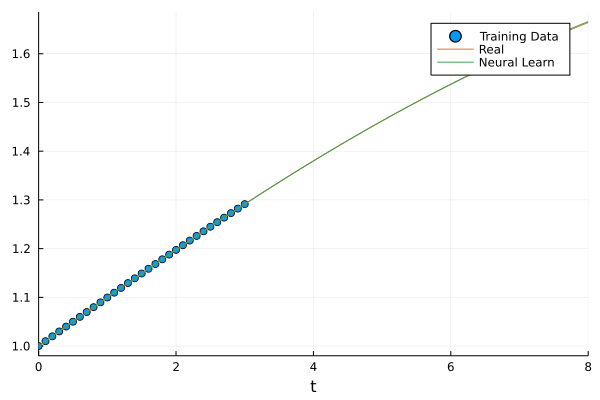

In [8]:
function model2(du,u,p,t)
    r, α = p
   du .= r.*u.*(1 .- u./α)
end
u_0 = [1.0]
p_data = [0.2,2]
tspan_data = (0.0, 3.0)
prob_data_1 = ODEProblem(model2,u_0,tspan_data,p_data)
data_solve = solve(prob_data_1, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois
tspan_predict = (0.0, 8.0)
prob_predict = ODEProblem(model2,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(1, 32,tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
function model2_nn(du,u,p,t)
    du[1] =  ann_node(u,p)[1]
end
prob_nn = ODEProblem(model2_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
println(res2_node.minimizer)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data, label="Real")

prob_nn2 = ODEProblem(model2_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label="Neural Learn")

Compare 
$$f(u)=0.2u(1-u/2), NN(u)$$

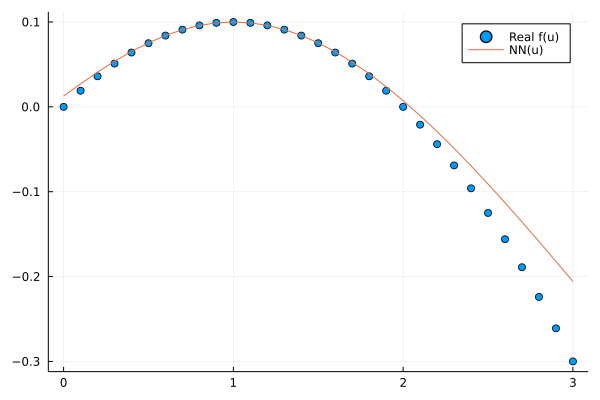

In [9]:
scatter(data_solve.t, 0.2.*data_solve.t.*(1 .- data_solve.t./2), label = "Real f(u)")
plot!(data_solve.t, ann_node(data_solve.t',res2_node.minimizer)',label="NN(u)")

0.03846794042640197


0.0032110773424427787
0.001946082789455385
0.0011319252415452072
0.0006303956784835342
0.0003562184704690777
0.0002217487213426007
0.0001621328022304013
0.00013811029018269058
0.00012926244121430164
3.2647132899014383e-8
[-0.4713836765483283, -0.006488315480497361, 0.053122720249719674, -0.027227106962728904, -0.6384384081454236, -0.1992242259738214, 0.11071326427594635, -0.1656742659206628, -0.013395288901043698, 0.15203542796018904, -0.5078385633218296, 0.1030671067709141, 0.23826928078003629, 0.07207883444167365, -0.18792666840705496, 0.08292269935840366, 0.19037542316883704, -0.15764153186763122, 0.5798265642738439, -0.19742053938038626, -0.301847088596468, -0.2023798707192997, 0.3057283181145173, 0.0939641871439975, -0.22207558428186178, -0.4370096500678802, -0.3087548357227197, 0.0056190098470981255, -0.1967545434323316, -0.16296113828135983, 0.230398052472485, -0.17344125791213783, -0.07959902290960477, 0.028249136449149254, -0.10788940966582064, -0.02745934986076821, 0.10922357

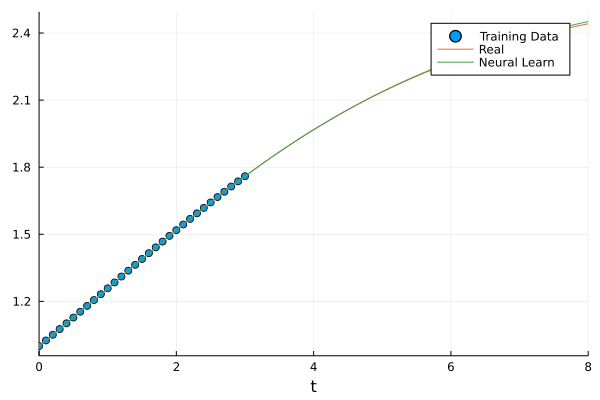

In [10]:
function model2(du,u,p,t)
    r, α = p
   du .= r.*u.*exp.(-r.*u).*(1 .- u./α) + r.* sin.(u)
end
u_0 = [1.0]
p_data = [0.2,2]
tspan_data = (0.0, 3.0)
prob_data_1 = ODEProblem(model2,u_0,tspan_data,p_data)
data_solve = solve(prob_data_1, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois
tspan_predict = (0.0, 8.0)
prob_predict = ODEProblem(model2,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(1, 32,tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
function model2_nn(du,u,p,t)
    du[1] =  ann_node(u,p)[1]
end
prob_nn = ODEProblem(model2_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Tsit5(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6))#,sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
#println(train(p))
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.02), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 2000)
println(res2_node.minimizer)
scatter(data_solve.t, data[1,:],label = "Training Data")
plot!(test_data, label="Real")

prob_nn2 = ODEProblem(model2_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label="Neural Learn")

Compare 
$$f(u)=0.2u\exp(-0.2u)(1-u/2)+0.2 sin(u), NN(u)$$

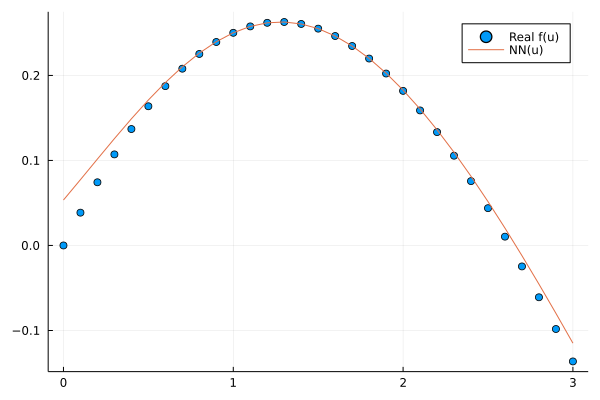

In [11]:
f(x) = 0.2.*x.*exp.(-0.2.*x).*(1 .- x./2) + 0.2.* sin.(x)
scatter(data_solve.t, f(data_solve.t), label = "Real f(u)")
plot!(data_solve.t, ann_node(data_solve.t',res2_node.minimizer)',label="NN(u)")

## 1.1.2 SIR model without natural birth and deth
As a second example, UDE is applied to discover the quadratic or subexponential growth
Focusing on the unclear incidence rate, the following examples are tested:
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = -\beta S^\alpha I^\beta,\\
&\frac{\rm{d}I}{\rm{dt}} = \beta S^\alpha I^\beta- \gamma I
\end{aligned}$$
to generate data with noise, and use the following universal differential equation to learn the model.
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = -NN(S,I),\\
&\frac{\rm{d}I}{\rm{dt}} = NN(S,I)- \gamma I,
\end{aligned}.$$
where $NN$ is a deep neural network.  

Generation data and trianing by UDE

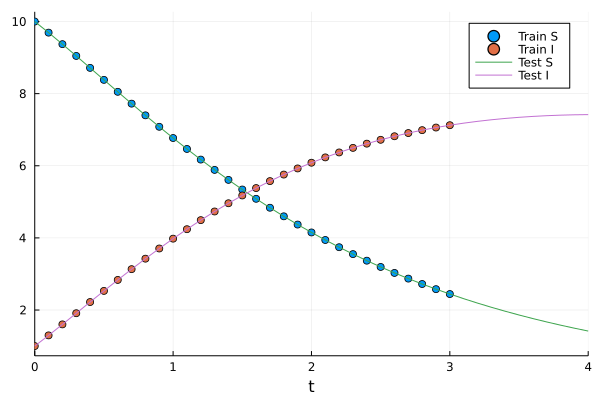

In [12]:
# Data generation
α,β = 1,1
function SIR(du,u,p,t)
     β, γ = p
    S, I = u
    du[1] = - β*S^α*I^β
    du[2] = β*S^α*I^β - γ*I
end
u_0 = [10, 1]
p_data = [0.3,0.1]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
plot!(test_data, label=["Test S" "Test I"])




## Define UDE

1.922574315012735


0.10795056632270118
0.07278046972183369
0.04828476216906139
0.03088152629995883
0.01963939860264388
0.01329107693966258
0.010248271613603267
0.009004505532859246
0.008547486592453243
4.247154788895069e-5
1.5127839369593852e-6
4.6500931621857935e-7
2.7952091575866543e-7
2.700045352062499e-7
1.8104661379662341e-7
8.314245415511662e-8
2.5136495974664434e-8
1.9377284527998302e-8
3.7068234959439808e-9
1.833272341054282e-9
1.0273059593951058e-9
8.028194216963668e-10
7.775638611119001e-10
7.660311412061531e-10
7.264592900702444e-10
5.765545037886898e-10
4.400813269714341e-10
3.1050689624055944e-10
2.0816906791787557e-10


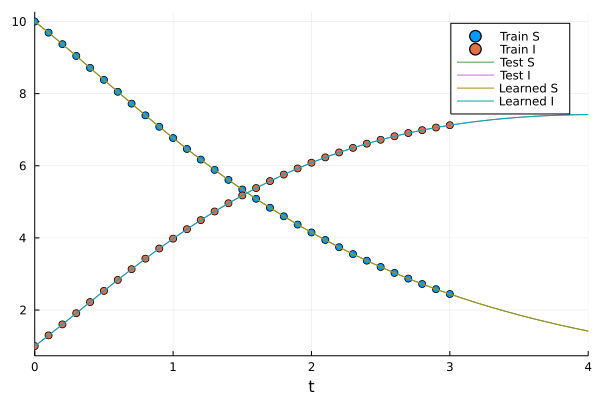

In [13]:
ann_node = FastChain(FastDense(2, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = 0.1
function SIR_nn(du,u,p,t)
    γ = p_know
    S, I = u
    du[1] =  - ann_node([S,I],p)[1]
    du[2] = ann_node([S,I],p)[1] - γ*I
    [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])

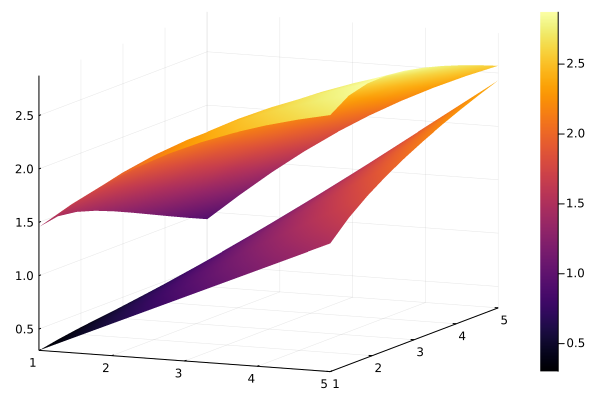

In [14]:
x=range(1.0,5,length=10)
y=range(1.0,5,length=10)
f(x,y) = 0.3*x*y^0.3
g(x,y) = ann_node([x,y],res2_node.minimizer)[1]

plot(x,y,f,st = [:surface], label = "true f(S,I)")
plot!(x,y,g,st = [:surface])

61.32572324618432


26.43379029496544
22.38462033594096
21.0417261386582
20.011014155930148
19.0122717937288
17.99640691740018
16.552331371479656
15.441979315166003
14.493240364320766
0.010672678360983505
0.001059323305415474
1.4684536307443283e-5
5.2019921192575635e-6
2.5794618114886005e-6
1.957664003435124e-6
1.5537310012203702e-6
1.3999021180510964e-6
5.239052262760933e-7
4.3733283874939814e-7
3.815730955144037e-7
3.500855672266715e-7
3.458814632545265e-7
3.436846567710125e-7
2.8252411069207864e-7
1.6014884005647676e-7
1.5030828679147913e-7
1.5031577353532925e-7
1.5032326304684528e-7
1.50330761490243e-7


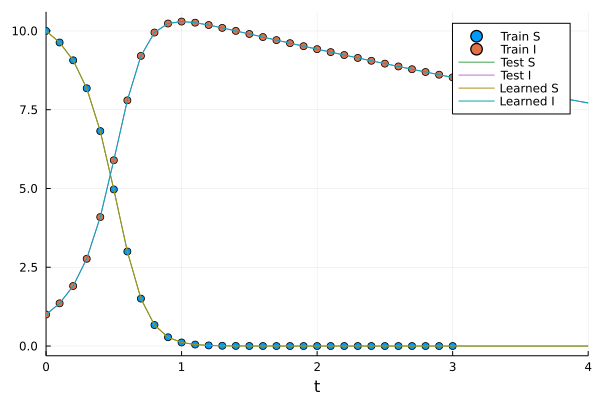

In [43]:
# Data generation
function SIR(du,u,p,t)
     β, γ, α, k = p
    S, I = u
    du[1] = - β*S*exp(-α*I)*I^k
    du[2] = β*S*exp(-α*I)*I^k - γ*I
end
u_0 = [10, 1]
p_data = [0.3,0.1,0.01,1.5]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(2, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = 0.1
function SIR_nn(du,u,p,t)
    γ = p_know
    S, I = u
    du[1] =  - ann_node([S,I],p)[1]
    du[2] = ann_node([S,I],p)[1] - γ*I
    [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
function train(θ)
    Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
    pred = train(θ)
    sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
    push!(losses, l)
    if length(losses)%50==0
        println(losses[end])
    end
    false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])

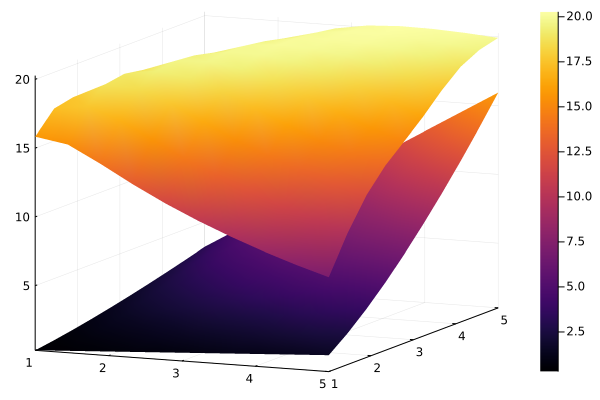

In [44]:
x=range(1.0,5,length=10)
y=range(1.0,5,length=10)
f(x,y) = 0.3*x*exp(-0.01*y)*y^1.5
g(x,y) = ann_node([x,y],res2_node.minimizer)[1]

plot(x,y,f,st = [:surface], label = "true f(S,I)")
plot!(x,y,g,st = [:surface])

73.41207257575775


49.27502570108912
37.33729184885042
23.615077690762494
11.494931214787238
5.144821286125854
3.029047015084829
2.3144497997665563
2.010806575389993
1.84577561986455
0.02109264584099381
0.00011928100727887486
2.0802392122792256e-5
1.572108133099021e-5
9.720608749201665e-6
6.261511266792342e-6
4.372378705549793e-6
3.5327457491366848e-6
3.0189607143952093e-6
1.9982137119209654e-6
2.66190324970308e-7
1.7754720816228406e-7
1.1527236366583391e-7
4.241498194454481e-8
1.991087097549364e-8
1.653637324375371e-8
1.5575426275410614e-8
1.4721760446370624e-8
1.3289257306400191e-8
1.2535040830291792e-8


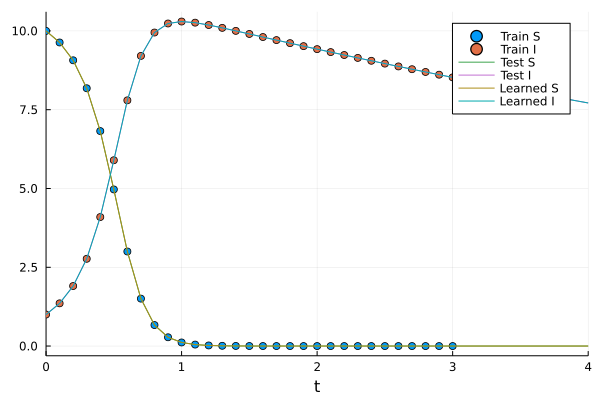

In [16]:
# Data generation
function SIR(du,u,p,t)
    β, γ, α, k = p
   S, I = u
   du[1] = - β*S*exp(-α*I)*I^k
   du[2] = β*S*exp(-α*I)*I^k - γ*I
end
u_0 = [10, 1]
p_data = [0.3,0.1,0.01,1.5]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(SIR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SIR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(1, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = 0.1
function SIR_nn(du,u,p,t)
   γ = p_know
   S, I = u
   du[1] =  - S*ann_node(I,p)[1]
   du[2] = S*ann_node(I,p)[1] - γ*I
   [du[1],du[2]]
end
prob_nn = ODEProblem(SIR_nn, u_0, tspan_data, p)
function train(θ)
   Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter!(data_solve.t, data[2,:],label = "Train I")
plot!(test_data, label=["Test S" "Test I"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learned S" "Learned I"])

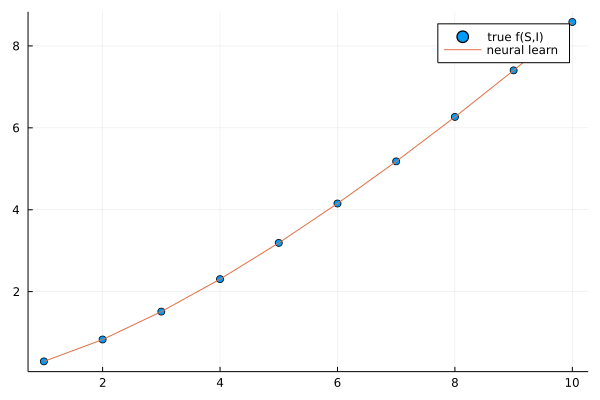

In [21]:
x=range(1.0,10,length=10)
y=range(1.0,10,length=10)
f(x) = 0.3*exp(-0.01*x)*x^1.5
g(x) = ann_node(x,res2_node.minimizer)[1]

scatter(x,f.(x), label = "true f(S,I)")
plot!(x,g.(x),label = "neural learn")

## 1.1.2 SEIAR model without natural birth and denth
As a second example, UDE is applied to discover the quadratic or subexponential growth
Focusing on the unclear incidence rate, the following examples are tested:
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = -\beta S^\alpha I^\beta,\\
&\frac{\rm{d}I}{\rm{dt}} = \beta S^\alpha I^\beta- \gamma I
\end{aligned}$$
to generate data with noise, and use the following universal differential equation to learn the model.
$$ \begin{aligned}
& \frac{\rm{d}S}{\rm{dt}} = -NN(S,I),\\
&\frac{\rm{d}I}{\rm{dt}} = NN(S,I)- \gamma I,
\end{aligned}.$$
where $NN$ is a deep neural network.  

In [45]:
# Data generation
function SEIAR(du,u,p,t)
    β, k1, k2, σ, ρ, γ1, γ2 = p
   S, E, I, A = u
   du[1] = - β*S*(I^0.5+k1*E^1.3+k2*A^1.2)
   du[2] = β*S*(I^0.5+k1*E^1.3+k2*A^1.2) - σ*E
   du[3] =  σ*(1-ρ)*E-γ1*I
   du[4] = σ*ρ*E-γ2*A
end
u_0 = [1, 0.0,0.001,0.0]
p_data = [0.3,0.3,0.3,1/5.2,0.3,1/10,1/10]
tspan_data = (0.0, 3.0)
prob_data = ODEProblem(SEIAR,u_0,tspan_data,p_data)
data_solve = solve(prob_data, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)
data_withoutnois = Array(data_solve)
data = data_withoutnois #+ Float32(2e-1)*randn(eltype(data_withoutnois), size(data_withoutnois))
tspan_predict = (0.0, 4.0)
prob_predict = ODEProblem(SEIAR,u_0,tspan_predict,p_data)
test_data = solve(prob_predict, Tsit5(),abstol=1e-12, reltol=1e-12, saveat = 0.1)

ann_node = FastChain(FastDense(3, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = [1/5.2,0.3,1/10,1/10]
function SEIAR_nn(du,u,p,t)
   σ, ρ, γ1, γ2 = p_know
  S, E, I, A = u
  du[1] = - S*ann_node([E,I,A],p)[1]
  du[2] = S*ann_node([E,I,A],p)[1] - σ*E
  du[3] =  σ*(1-ρ)*E-γ1*I
  du[4] = σ*ρ*E-γ2*A
end
prob_nn = ODEProblem(SEIAR_nn, u_0, tspan_data, p)
function train(θ)
   Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 0.1,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (data .- pred)), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
#println(loss(p))
const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
scatter(data_solve.t, data[1,:],label = "Train S")
scatter(data_solve.t, data[2,:],label = "Train E")
scatter!(data_solve.t, data[3,:],label = "Train I")
scatter!(data_solve.t, data[3,:],label = "Train A")
plot!(test_data, label=["Test S" "Test E" "Test I" "Test A"])


prob_nn2 = ODEProblem(SIR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn,label=["Learn S" "Learn E" "Learn I" "Learn A"])

0.003729170999465343


0.0021733840309929647
0.0006981251723498497
0.002691675042013948
0.0014391395450646651
0.0005803889878906196
0.00012239802178883136
1.0830279163901519e-5
5.910891030744281e-7
0.0005377275456864137
1.7110197669641242e-7
1.7073450293278452e-7
1.7000216627279658e-7
1.6957441851722935e-7
1.692482623832087e-7
1.6893302451167379e-7
1.686699333799305e-7
1.6844261217773098e-7
1.6822963699846012e-7
1.6802765480917866e-7
1.6783190516003805e-7
1.676468130510867e-7
1.6746052711301802e-7
1.6726472032878388e-7
1.6709737466902565e-7
1.6696233798923243e-7
1.6682354840110916e-7
1.666635563298486e-7
1.665050832806306e-7
1.6636625101199855e-7


LoadError: DimensionMismatch("second dimension of A, 3, does not match length of x, 2")

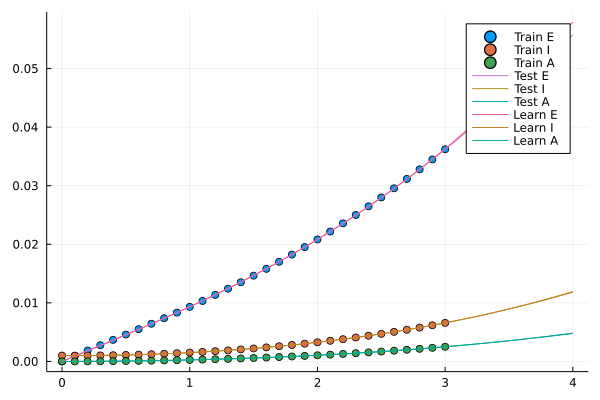

In [56]:
#scatter(data_solve.t, data[1,:],label = "Train S")
scatter(data_solve.t, data[2,:],label = "Train E")
scatter!(data_solve.t, data[3,:],label = "Train I")
scatter!(data_solve.t, data[4,:],label = "Train A")
plot!(test_data.t, Array(test_data)[2:4,:]',label=["Test E" "Test I" "Test A"])


prob_nn2 = ODEProblem(SEIAR_nn, u_0, tspan_predict, res2_node.minimizer)
s_nn = solve(prob_nn2, Tsit5(), saveat = 0.1)
plot!(s_nn.t, Array(s_nn)[2:4,:]',label=["Learn E" "Learn I" "Learn A"])

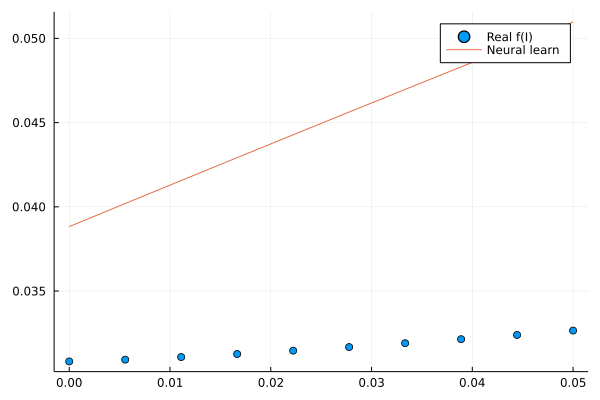

In [60]:
x = range(0,0.05,length=10)
I = 0.01
A = 0.02
f(x) = 0.3*(I^0.5+0.3*x^1.3+0.3*A^1.2)
g(x) = ann_node([x,I,A],res2_node.minimizer)[1]
scatter(x,f.(x),label= "Real f(I)")
plot!(x,g.(x),label = "Neural learn")

# Chapter 2. Using Covid-19 Cases

## 2.1. Tidy the data

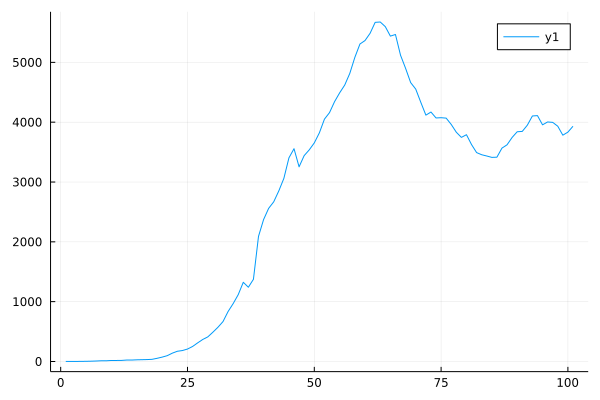

1

In [3]:
using CSV
using DataFrames
source_data = DataFrame(CSV.File("Provincial_Daily_Totals.csv"))
data_on = source_data[source_data.Province .== "ONTARIO", :]
n = 30
display(plot(data_on.TotalActive[n:n+100]))
data = data_on.TotalActive[n:n+100]
data[1]

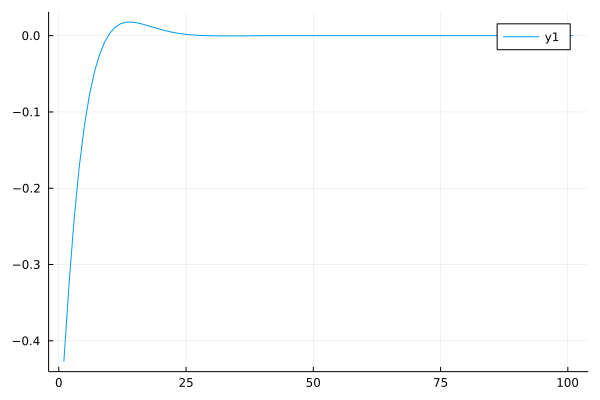

(13200.087960973819, [-0.427010912339449, -0.3268237227743118, -0.24159786532921154, -0.17293202870644714, -0.11940300391091832, -0.07851643706744982, -0.047756217515377786, -0.02498942285077338, -0.008524442841727486, 0.0029663227060936492, 0.01054569154724333, 0.015088352752166245, 0.01732764059075903, 0.01787995521091862, 0.017256983784032176, 0.015873505741936245, 0.014055145818817949, 0.012047701989699677, 0.010028013855627571, 0.008115609810942115, 0.006384236137331023, 0.0048725392433255355, 0.0035934412262924598, 0.002541992087518319, 0.0017016866594155577, 0.0010493482326527914, 0.0005587530775439942, 0.00020320650570310184, -4.273601604937172e-5, -0.00020221047696172834, -0.0002954808844257695, -0.00033973944854770455, -0.0003491558013094531, -0.0003350842243422525, -0.0003063646472059034, -0.0002696685822740075, -0.0002298516145808338, -0.00019029190536878904, -0.00015319885027842428, -0.00011988348410313376, -9.098941367663427e-5, -6.668404258425298e-5, -4.68112796663811e-5

In [4]:

ann_node = FastChain(FastDense(3, 32, tanh),FastDense(32, 1))
p = Float64.(initial_params(ann_node))
p_know = [1/5.2,0.3,1/10,1/10]
const N = 14570000.0
function SEIAR_nn(du,u,p,t)
   σ, ρ, γ1, γ2 = p_know
  S, E, I, A, H = u
  du[1] = - S*ann_node([E,I,A],p)[1]/N
  du[2] = S*ann_node([E,I,A],p)[1]/N - σ*E
  du[3] =  σ*(1-ρ)*E-γ1*I
  du[4] = σ*ρ*E-γ2*A
  du[5] = S*ann_node([E,I,A],p)[1]/N
end
u_0 = [N,0,1,0,1]
tspan_data = [0.0, 101.0]
prob_nn = ODEProblem(SEIAR_nn, u_0, tspan_data, p)
solvedata1 = Array(concrete_solve(prob_nn, Vern7(), u_0, p, saveat = 1,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
data_test = solvedata1[5,2:end] .- solvedata1[5,1:end-1]
display(plot(data_test))
function train(θ)
   solvedata = Array(concrete_solve(prob_nn, Vern7(), u_0, θ, saveat = 1,
                        abstol=1e-6, reltol=1e-6,
                        sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())));
   solvedata[5,2:end] .- solvedata[5,1:end-1]
end
function loss(θ)
   pred = train(θ)
   sum(abs2, (log.(abs.(data).+0.01) .- log.(abs.(pred).+0.01))), pred # + 1e-5*sum(sum.(abs, params(ann)))
end
println(loss(p))

const losses = []
callback(θ,l,pred) = begin
   push!(losses, l)
   if length(losses)%50==0
       println(losses[end])
   end
   false
end
res1_node = DiffEqFlux.sciml_train(loss, p, ADAM(0.05), cb=callback, maxiters = 500)
res2_node = DiffEqFlux.sciml_train(loss, res1_node.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)
